In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

from zipfile import ZipFile
from PIL import Image
from numpy import sqrt
import random
import csv

from sklearn.metrics import mean_squared_error
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

%matplotlib inline

In [ ]:
# variables

path = '/content/drive/MyDrive/COMP5328/COMP5328_assignment1/'
targetpath = path + 'data'
rng = np.random.RandomState(13)

Iter_step = 500
skip_step = 50
error = 1e-4

In [ ]:
# util functions

def unzip_file(sourcepath, targetpath):
  with ZipFile(sourcepath, 'r') as f:
    f.extractall(path=targetpath)

def load_data(root='data/CroppedYaleB', reduce=1):
    """
    Load ORL (or Extended YaleB) dataset to numpy array.

    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.

    """

    root = path + root



    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):

        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):

            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue

            if not fname.endswith('.pgm'):
                continue

            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

# get_image_size
def get_image_size(datatype, reduce=1):

  if datatype == 'data/ORL':
    image_size = [i // reduce for i in (92, 112)]
  elif datatype == 'data/CroppedYaleB':
    image_size = [i // reduce for i in (168, 192)]
  return np.array(image_size)

In [ ]:
# unzip data files run only once
# unzip_path = path + 'data/CroppedYaleB.zip'
# unzip_file(unzip_path, targetpath)
# unzip_path = path + 'data/ORL.zip'
# unzip_file(unzip_path, targetpath)

In [ ]:
# Load ORL dataset.
X_hat, Y_hat = load_data(root= 'data/ORL', reduce=2)
print('ORL dataset: X_hat.shape = {}, Y_hat.shape = {}'.format(X_hat.shape, Y_hat.shape))

# Load Extended YaleB dataset.
X_hat, Y_hat = load_data(root='data/CroppedYaleB',  reduce=4)
print('Extended YalB dataset: X_hat.shape = {}, Y_hat.shape = {}'.format(X_hat.shape, Y_hat.shape))

ORL dataset: X_hat.shape = (2576, 400), Y_hat.shape = (400,)
Extended YalB dataset: X_hat.shape = (2016, 2414), Y_hat.shape = (2414,)


In [ ]:
# define nmf algorithms
# different kinds of NMF models

class Base():

    def __init__(
            self,
            n_components,
            iter_step):
        self.n_components = n_components
        self.iter_step = iter_step

    def _loss(self, X, D, R):
        return None

    def _update(self, X, D, R):
        return None

    def _init(self, X):

        n_features, n_samples = X.shape
        avg = np.sqrt(X.mean() / self.n_components)
        D = avg * rng.randn(n_features, self.n_components)
        R = avg * rng.randn(self.n_components, n_samples)
        np.abs(D, out=D)
        np.abs(R, out=R)

        return D, R


    def fit(self, X):

        D, R = self._init(X)
        losses = [self._loss(X, D, R)]
        for i in range(self.iter_step):
            D, R = self._update(X, D, R)
            losses.append(self._loss(X, D, R))
            if i % skip_step == 0:
              print('step:{:>4},  {:>10}'.format(i, losses[-1]))
            crit = abs(losses[-1] - losses[-2]) / losses[-2]
            if crit < error:
              break

        return D, R


class NMF_withweight(Base):
    def __init__(
            self,
            n_components,
            iter_step=500):
        super().__init__(n_components, iter_step)

    def _loss(self, X, D, R):
        return None

    def _update_weightmatrix(self, X, D, R):
        return None

    def _update(self, X, D, R):
        # update w
        W = self._update_weightmatrix(X, D, R)
        # update D
        denominator_D = (W * D.dot(R)).dot(R.T)
        denominator_D[denominator_D == 0] = np.finfo(np.float32).eps
        D = D * ((W * X).dot(R.T)) / denominator_D
        # update R
        denominator_R = D.T.dot(W * D.dot(R))
        denominator_R[denominator_R == 0] = np.finfo(np.float32).eps
        R = R * (D.T.dot(W * X)) / denominator_R
        return D, R


class NMF_standard(NMF_withweight):
    # Standard NMF
    def _loss(self, X, D, R):
        return np.linalg.norm(X - D.dot(R)) ** 2

    def _update_weightmatrix(self, X, D, R):
        return 1


class NMF_L1norm(NMF_withweight):
    # L1 norm based NMF
    def _loss(self, X, D, R):
        return np.sum(np.abs(X - D.dot(R)))

    def _update_weightmatrix(self, X, D, R):

        eps = X.var() / D.shape[1]
        return 1 / (np.sqrt(np.square(X - D.dot(R))) + eps ** 2)

class NMF_L21norm(NMF_withweight):
    # L1,2 norm NMF
    def _loss(self, X, D, R):
        return np.sum(np.sqrt(np.sum(np.square(X - D.dot(R)), axis=0)))

    def _update_weightmatrix(self, X, D, R):
        return 1 / np.sqrt(np.sum(np.square(X - D.dot(R)), axis=0))


class NMF_L1NormR(Base):

    def __init__(
            self,
            n_components,
            iter_step=500,
            lambda_=128):
        self.lambda_=128
        super().__init__(n_components, iter_step)

    def _loss(self, X, D, R, E):
        return (np.linalg.norm(X - D.dot(R) - E) ** 2 + self.lambda_ * np.sum(np.abs(E)))

    def _update(self, X, D, R):
        # E
        E = X - D.dot(R)
        index_greater = E > self.lambda_ / 2
        E[index_greater] = E[index_greater] - self.lambda_ / 2
        index_less = E < -self.lambda_ / 2
        E[index_less] = E[index_less] + self.lambda_ / 2
        E[np.logical_not(np.logical_or(index_greater, index_less))] = 0
        # update D
        E_minus_X = E - X
        E_minus_X_dot_RT = (E_minus_X).dot(R.T)
        denominator_D = 2 * D.dot(R).dot(R.T)
        denominator_D[denominator_D == 0 ] = np.finfo(np.float32).eps
        D = (D * (np.abs(E_minus_X_dot_RT) - E_minus_X_dot_RT) /
             denominator_D)
        # update R
        DT_dot_E_minus_X = D.T.dot(E_minus_X)
        denominator_R = 2 * D.T.dot(D).dot(R)
        denominator_R[denominator_R == 0] = np.finfo(np.float32).eps
        R = (R * (np.abs(DT_dot_E_minus_X) - DT_dot_E_minus_X) /
             denominator_R)
        # normalize D and R
        # keepdims=True makes its shape to be [1, n_components]
        normalization = np.sqrt(np.sum(np.square(D), axis=0, keepdims=True))
        D = D / normalization
        R = R * normalization.T
        return D, R, E

    def fit(self, X):
        D, R = self._init(X)
        #print(D.shape, R.shape)
        losses = [self._loss(X, D, R, X - D.dot(R))]
        for i in range(self.iter_step):
            D, R, E = self._update(X, D, R)
            losses.append(self._loss(X, D, R, E))
            crit = abs(losses[-1] - losses[-2]) / losses[-2]
            if i % skip_step == 0:
              print('step:{:>4},  {:>10}'.format(i, losses[-1]))
            if crit < error:
              break
        return D, R

class HCNMF(Base):
# HCNMF
    def __init__(
            self,
            n_components,
            iter_step=500,
            alpha=0.001,
            beta=0.001):
        self.alpha = alpha
        self.beta = beta
        super().__init__(n_components, iter_step)

    def _loss(self, X, D, R):
        return np.sum(np.sqrt(1 + np.square(X - D.dot(R))) - 1)

    def _update(self, X, D, R):
        denominator = np.sqrt(1+np.linalg.norm(X - D.dot(R)))
        # update D by Armijo rule
        grad_D = (D.dot(R).dot(R.T) - X.dot(R.T)) / denominator
        D_updated = D - self.alpha * grad_D
        while self._loss(X, D_updated, R) > self._loss(X, D, R):
            self.alpha *= 0.5
            D_updated = D - self.alpha * grad_D
        D = D_updated
        # update D by Armijo rule
        grad_R = (D.T.dot(D).dot(R) - D.T.dot(X)) / denominator
        R_updated = R - self.beta * grad_R
        while self._loss(X, D, R_updated) > self._loss(X, D, R):
            self.beta *= 0.5
            R_updated = R - self.beta * grad_R
        R = R_updated
        return D, R


In [ ]:
# define noise addition methods

# add block noise
def add_block_noise(X, block_size, datatype, reduce):

  n_features, n_samples = X.shape
  image_size = get_image_size(datatype, reduce)
  X = X.copy().reshape((image_size[1], image_size[0], n_samples))
  head_index_y, head_index_x = image_size - block_size + 1
  for i in range(n_samples):
    index_x = rng.randint(head_index_x)
    index_y = rng.randint(head_index_y)
    X[index_x:index_x+block_size,index_y:index_y+block_size,i] = 255
  X = X.reshape((n_features, n_samples))
  return X

# add salt and pepper noise on X
def add_salt_pepper_noise(X, percentage):

    n_features, n_samples = X.shape
    X = X.copy()
    size = int(n_features * percentage)
    middle = size//2+1
    for i in range(n_samples):
      index = np.arange(n_features)
      rng.shuffle(index)
      X[index[:middle],i] = 0
      X[index[middle:size], i] = 255
    return X

# add random noise on X
def add_random_noise(X, beta=40):

    n_features, n_samples = X.shape
    X = X.copy()
    X_noise = np.random.rand(*X.shape) * beta
    X = X + X_noise
    return X

In [ ]:
# evaluation methods
# Evaluate Root Means Square Errors

def get_RMSE(D, R, X_hat):
  return sqrt(mean_squared_error(X_hat, D.dot(R)))

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y)),n_init='auto').fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

def get_Acc_NMI(R, Y_hat):
  Y_pred = assign_cluster_label(R.T, Y_hat)
  acc = accuracy_score(Y_hat, Y_pred)
  nmi = normalized_mutual_info_score(Y_hat, Y_pred)
  return acc, nmi

def get_evaluation_matrics(D,R,X_hat,Y_hat):
  RMSE = get_RMSE(D,R,X_hat)
  ACC, NMI = get_Acc_NMI(R, Y_hat)
  return RMSE,ACC,NMI

In [ ]:
# Load dataset for demonstrate noise, using ORL dataset
print('==> Load ORL dataset ...')
X_hat, Y_hat = load_data(root='data/ORL', reduce=2)
print('X_hat.shape={}, Y_hat.shape={}'.format(X_hat.shape, Y_hat.shape))

==> Load ORL dataset ...
X_hat.shape=(2576, 400), Y_hat.shape=(400,)


Demonstate block noise...


Text(0.5, 1.0, 'Image(Noised)')

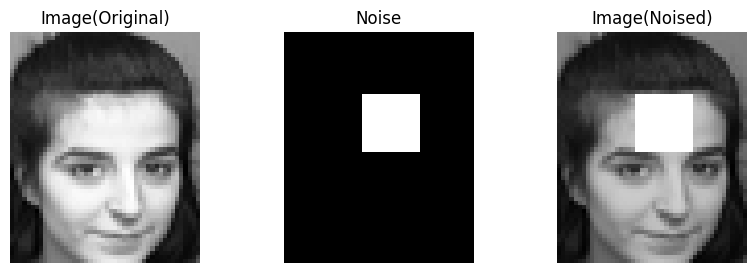

In [ ]:
# demonstrate each type of noise
# Add block noise
ind = 10 # index of demo image.
ind2= 11
n_features, n_samples = X_hat.shape
image_size = get_image_size('data/ORL',2)
block_size = 14
X_contaminated = X_hat.copy().reshape((image_size[1], image_size[0], n_samples))
X_noise = X_hat.copy().reshape((image_size[1], image_size[0], n_samples))
X_noise[:] = 0
head_index_x, head_index_y = image_size - block_size + 1
index_x = np.random.randint(head_index_x)
index_y = np.random.randint(head_index_y)
X_contaminated[index_x:index_x+block_size,index_y:index_y+block_size,ind] = 255
X_noise[index_x:index_x+block_size,index_y:index_y+block_size,ind] = 255
X_contaminated = X_contaminated.reshape((n_features, n_samples))
X_noise = X_noise.reshape((n_features, n_samples))

# Plot result:  show the original image as well as the image contaminated by noise
print("Demonstate block noise...")
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(X_hat[:,ind].reshape(image_size[1],image_size[0]), cmap=plt.cm.gray)
plt.axis('off')
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(X_noise[:,ind].reshape(image_size[1],image_size[0]), cmap=plt.cm.gray)
plt.axis('off')
plt.title('Noise')
plt.subplot(133)
plt.imshow(X_contaminated[:,ind].reshape(image_size[1],image_size[0]), cmap=plt.cm.gray)
plt.axis('off')
plt.title('Image(Noised)')

Demonstate salt and pepper noise...


Text(0.5, 1.0, 'Image(Noised)')

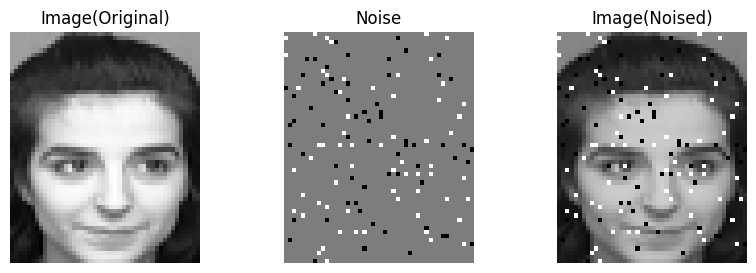

In [ ]:
# Add pepper and salt noise
ind = 11 # index of demo image.
n_features, n_samples = X_hat.shape
image_size = get_image_size('data/ORL',2)
percentage = 0.05
size = int(n_features * percentage)
middle = size//2+1
index = np.arange(n_features)
np.random.shuffle(index)

X_contaminated = X_hat.copy()
X_noise = X_hat.copy()
X_noise[:] = 125

X_contaminated[index[:middle],ind] = 0
X_contaminated[index[middle:size], ind] = 255

X_noise[index[:middle],ind] = 0
X_noise[index[middle:size], ind] = 255

X_contaminated = X_contaminated.reshape((n_features, n_samples))
X_noise = X_noise.reshape((n_features, n_samples))

# Plot result:  show the original image as well as the image contaminated by noise

print("Demonstate salt and pepper noise...")
image_size = get_image_size(datatype='data/ORL', reduce=2)
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(X_hat[:,ind].reshape(image_size[1],image_size[0]), cmap=plt.cm.gray)
plt.axis('off')
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(X_noise[:,ind].reshape(image_size[1],image_size[0]), cmap=plt.cm.gray)
plt.axis('off')
plt.title('Noise')
plt.subplot(133)
plt.imshow(X_contaminated[:,ind].reshape(image_size[1],image_size[0]), cmap=plt.cm.gray)
plt.axis('off')
plt.title('Image(Noised)')


Experiment on ORL dataset...
Loading ORL dataset...
ORL dataset: X_hat.shape = (2576, 390), Y_hat.shape = (390,)
Adding noise...
Adding salt and pepper noise with percentage 0.05
Constructing model_HCNMF model...
Training...
step:   0,  42623627.59094124
step:  50,  30359486.47426396
step: 100,  24567997.818964563
step: 150,  22172666.752923302
step: 200,  20860653.665203195
step: 250,  20110093.825839598
step: 300,  19678301.2046442
step: 350,  19430033.20983869
step: 400,  19267632.10070309
step: 450,  19147170.30000757
Evaluating...
Evaluation matrics on dataset:data/ORL noiseType:sp modelType:model_HCNMF Iter_step:500
  RMSE   |  ACC     |  NMI   
20.1449  |  0.7410  |  0.8675 
recontruct image...


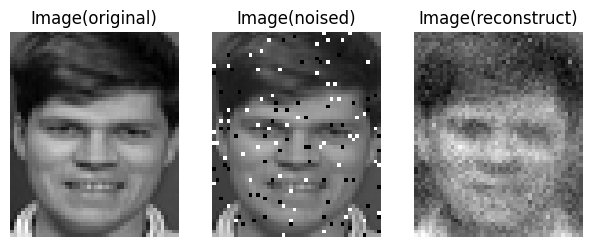

(array([[ 1.8371595 ,  2.59266126,  0.22132609, ...,  0.8958485 ,
          3.7497339 ,  3.25086377],
        [ 2.6938439 ,  2.54168229, -0.19134338, ...,  1.27808364,
          2.89644869,  2.07686333],
        [ 2.93555395,  2.82918905, -0.71368034, ...,  1.07128494,
          2.83930249,  1.87462608],
        ...,
        [-0.27481637, -3.85049016,  0.84476684, ..., -0.24961859,
          3.18040372, -1.74235073],
        [-0.06255947, -3.22366278,  1.7959539 , ...,  1.68636122,
          2.98376847, -3.55914825],
        [-0.44479724, -3.32291079,  2.50017681, ...,  0.94447988,
          2.27693773, -2.48080149]]),
 array([[-0.56387743,  2.43621574,  2.70206292, ...,  1.22673488,
          1.7790279 , -2.07123075],
        [ 0.79706359,  5.92770161,  3.97606656, ..., -1.00395022,
         -1.09698082,  2.15827721],
        [-2.13567555,  4.69125682, -0.62238316, ..., -3.51083173,
          4.74880986,  6.11952483],
        ...,
        [-0.52825176, -1.24292215, -0.06032666, ...,  

In [ ]:
experiment('data/ORL', 2, 'sp','model_HCNMF')

Experiment on Extended YaleB dataset...
Loading Extended YaleB dataset...
YaleB dataset: X_hat.shape = (8064, 2172), Y_hat.shape = (2172,)
Adding noise...
Adding salt and pepper noise with percentage 0.1
Constructing model_L1RNMF model...
Training...
step:   0,  65882154516.69282
step:  50,  32165365967.265842
step: 100,  29306535510.659393
step: 150,  28310607143.305676
step: 200,  27895770723.281517
Evaluating...
Evaluation matrics on dataset:data/CroppedYaleB noiseType:sp modelType:model_L1RNMF Iter_step:500
  RMSE   |  ACC     |  NMI   
19.3268  |  0.2238  |  0.3142 
recontruct image...


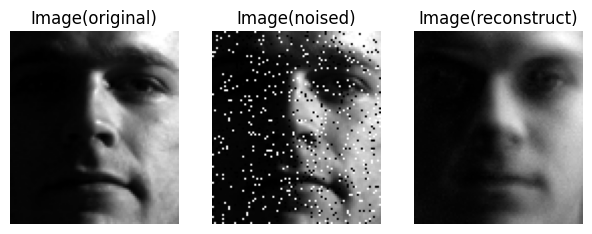

(array([[6.24988989e-05, 2.36455320e-03, 1.47809331e-05, ...,
         3.91096762e-04, 4.46066987e-04, 9.14053667e-07],
        [2.21393130e-07, 1.76606563e-03, 9.26923378e-04, ...,
         2.36456802e-06, 5.06644916e-04, 9.62643809e-07],
        [3.17682487e-09, 3.22108622e-03, 2.17650547e-04, ...,
         1.18059993e-04, 3.29682097e-03, 5.30168237e-05],
        ...,
        [6.91146454e-03, 3.93285883e-09, 5.80634033e-04, ...,
         2.34265257e-03, 3.14806925e-03, 1.14018117e-05],
        [5.67111789e-03, 1.15525567e-09, 4.26517694e-06, ...,
         4.77740307e-04, 4.03077565e-03, 2.36698187e-03],
        [8.34289506e-03, 2.48863552e-10, 2.16521178e-07, ...,
         7.11275301e-06, 6.01229928e-03, 6.20870328e-04]]),
 array([[2.36891796e+02, 4.40227594e+01, 4.36283383e+02, ...,
         9.91570296e+02, 8.46183087e+02, 1.17072941e-01],
        [1.97784661e+02, 2.05445100e-02, 3.65295353e+02, ...,
         3.71710009e-01, 5.08695963e+00, 1.02287969e+02],
        [1.85424689e+02, 

In [ ]:
experiment('data/CroppedYaleB', 2, 'sp','model_L1RNMF', percentage=0.1)

In [ ]:
# experiment function
# dataType : 'data/ORL' or 'data/CroppedYaleB'
# noiseType : 'b' for block noise, 'sp' for salt and pepper noise
# modelType : 'model_stdNMF' for NMF_standard, 'model_L1NMF' for NMF_L1norm, 'model_L21NMF' for NMF_L21norm,
# 'model_L1RNMF' for NMF_L1NormR, 'model_HCNMF' for HCNMF
def experiment(dataType, reduce, noiseType, modelType, block_size=10, percentage=0.05, index=10):
  # Load ORL dataset.
  if dataType == 'data/ORL':
    n_components = 40
    print("Experiment on ORL dataset...")
    print("Loading ORL dataset...")
    X_hat, Y_hat = load_data(root= dataType, reduce=reduce)
    # split the data
    indexORL = random.sample(range(400), 390)
    X_hat = X_hat[:, indexORL]
    Y_hat = Y_hat[indexORL]
    n_features, n_samples = X_hat.shape
    image_size = get_image_size('data/ORL', reduce=reduce)
    print('ORL dataset: X_hat.shape = {}, Y_hat.shape = {}'.format(X_hat.shape, Y_hat.shape))
  elif dataType == 'data/CroppedYaleB':
    n_components = 38
    print("Experiment on Extended YaleB dataset...")
    print("Loading Extended YaleB dataset...")
    X_hat, Y_hat = load_data(root= dataType, reduce=reduce)
    # split the data
    indexYal = random.sample(range(2414), 2172)
    X_hat = X_hat[:, indexYal]
    Y_hat = Y_hat[indexYal]
    n_features, n_samples = X_hat.shape
    image_size = get_image_size('data/CroppedYaleB', reduce=reduce)
    print('YaleB dataset: X_hat.shape = {}, Y_hat.shape = {}'.format(X_hat.shape, Y_hat.shape))

  # Add noise
  print("Adding noise...")
  if noiseType == 'b':
    # block noise with different block size (10,12,14)
    print(f"Adding block noise with block size {block_size}")
    X = add_block_noise(X_hat, block_size, dataType, reduce=reduce)
  elif noiseType == 'sp':
    print(f"Adding salt and pepper noise with percentage {percentage}")
    X = add_salt_pepper_noise(X_hat, percentage)

  # construct model
  print(f"Constructing {modelType} model...")
  if modelType == 'model_stdNMF':
    model = NMF_standard(n_components,Iter_step)
  elif modelType == 'model_L1NMF':
    model = NMF_L1norm(n_components,Iter_step)
  elif modelType == 'model_L21NMF':
    model = NMF_L21norm(n_components,Iter_step)
  elif modelType == 'model_L1RNMF':
    model = NMF_L1NormR(n_components,Iter_step)
  elif modelType == 'model_HCNMF':
    model = HCNMF(n_components,Iter_step)

  # Training
  print("Training...")
  D, R = model.fit(X)

  #Evaluation
  print("Evaluating...")
  RMSE,ACC,NMI = get_evaluation_matrics(D,R,X_hat,Y_hat)
  print(f"Evaluation matrics on dataset:{dataType} noiseType:{noiseType} modelType:{modelType} Iter_step:{Iter_step}")
  print("  RMSE   |  ACC     |  NMI   ")
  print("{:^8.4f} | {:^8.4f} | {:^8.4f}".format(RMSE,ACC,NMI))
  print("recontruct image...")
  X_reconstruct = D.dot(R)
  plt.figure(figsize=(10,3))
  plt.subplot(141)
  plt.imshow(X_hat[:,index].reshape(image_size[1],image_size[0]), cmap=plt.cm.gray)
  plt.axis('off')
  plt.title('Image(original)')
  plt.subplot(142)
  plt.imshow(X[:,index].reshape(image_size[1],image_size[0]), cmap=plt.cm.gray)
  plt.axis('off')
  plt.title('Image(noised)')
  plt.subplot(143)
  plt.imshow(X_reconstruct[:,index].reshape(image_size[1],image_size[0]), cmap=plt.cm.gray)
  plt.axis('off')
  plt.title('Image(reconstruct)')
  plt.show()

  return D,R,RMSE,ACC,NMI

In [ ]:
dataType = ['data/ORL', 'data/CroppedYaleB']
noiseTypes = ['b', 'sp']
modelTypes = ['model_stdNMF', 'model_L1NMF', 'model_L21NMF', 'model_HCNMF','model_L1RNMF']
block_sizes = [10, 12, 14]
percentages = [0.01, 0.05, 0.1]
D_list = []
R_list = []
RMSE_list = []
ACC_list = []
NMI_list = []

for data in dataType:
  for noise in noiseTypes:
    for i in range(3):
      for model in modelTypes:
        if data == 'data/ORL':
          re = 2
        elif data == 'data/CroppedYaleB':
          re = 4
        D,R,RMSE,ACC,NMI= experiment(dataType=data,reduce=re,noiseType=noise,modelType=model,block_size=block_sizes[i],percentage=percentages[i])
        D_list.append(D)
        R_list.append(R)
        RMSE_list.append(RMSE)
        ACC_list.append(ACC)
        NMI_list.append(NMI)



Experiment on ORL dataset...
Loading ORL dataset...
ORL dataset: X_hat.shape = (2576, 390), Y_hat.shape = (390,)
Adding noise...
Adding block noise with block size 10
Constructing model_stdNMF model...
Training...
step:   0,  2011028999.5643299
step:  50,  1092025573.0306053
step: 100,  743938869.5584464
step: 150,  642431251.4999948
step: 200,  603007916.7827194
step: 250,  583630354.6041037
step: 300,  572365961.4079349
step: 350,  564925696.8846439
step: 400,  559549171.8579563
step: 450,  555449957.770045
Evaluating...
Evaluation matrics on dataset:data/ORL noiseType:b modelType:model_stdNMF Iter_step:500
  RMSE   |  ACC     |  NMI   
29.5858  |  0.4513  |  0.6104 
Experiment on ORL dataset...
Loading ORL dataset...
ORL dataset: X_hat.shape = (2576, 390), Y_hat.shape = (390,)
Adding noise...
Adding block noise with block size 10
Constructing model_L1NMF model...
Training...
step:   0,  33610576.857677944
step:  50,  23820758.28927256
step: 100,  19825751.911488514
step: 150,  18498

In [ ]:
# !mkdir -p "/content/drive/MyDrive/COMP5328/COMP5328_assignment1/result"

In [ ]:
with open("/content/drive/MyDrive/COMP5328/COMP5328_assignment1/result/NMI_list(5).csv", 'w') as f:
  for item in NMI_list:
    f.write("%s\n" % item)
with open("/content/drive/MyDrive/COMP5328/COMP5328_assignment1/result/ACC_list(5).csv", 'w') as f:
  for item in ACC_list:
    f.write("%s\n" % item)
with open("/content/drive/MyDrive/COMP5328/COMP5328_assignment1/result/RMSE_list(5).csv", 'w') as f:
  for item in RMSE_list:
    f.write("%s\n" % item)

FileNotFoundError: ignored